## Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread

## Defining Activation Functions

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def relu(x):
    x[x < 0] = 0
    return x

def tanh(x):
    return np.tanh(x)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

## 2D convolution Function

In [3]:
def conv2d(image,filters, kernel, stride, activation, padding = 'valid'):
    # kernel size to work for both 2d and 3d input
    filter_shape = kernel
    if(len(image.shape) > 2):
        filter_shape = kernel + (image.shape[2],)
    
    #initializing parameters
    weights = np.random.normal(size = ((filters,) + filter_shape))
    bias = np.random.rand(filters)
    out = []
    
    #iterating over number of kernels
    for i in range(filters):
        if( i == 0):
            output = np.zeros((((image.shape[0] - kernel[0])/stride[0]) + 1 ,((image.shape[1] - kernel[1])/stride[1]) + 1))
        #taking care of padding
        if(padding == 'same' and i == 0):
            output = np.zeros(image.shape[0:2])
            #finding number of rows and cols to pad
            temp = ((image.shape[0] - 1)* stride[0]) + kernel[0] - image.shape[0]
            pad_size_rows = temp + temp%2
            temp = ((image.shape[1] - 1)* stride[1]) + kernel[1] - image.shape[1]
            pad_size_cols = temp + temp%2
            #padding the input
            if(len(image.shape) > 2):
                image = np.pad(image, ((pad_size_rows/2,),(pad_size_cols/2,),(0,)), 'constant')
            else:
                image = np.pad(image, ((pad_size_rows/2,),(pad_size_cols/2,)), 'constant')
        #to moniter the current positions of output and the input
        img_cur_row = 0
        out_cur_row = 0
        while(img_cur_row + kernel[0] <= image.shape[0] - 1):
            img_cur_col = 0
            out_cur_col = 0
            while(img_cur_col + kernel[1] <= image.shape[1] - 1):
                # convolution function
                if(len(image.shape) > 2):
                    output[out_cur_row , out_cur_col] = np.sum(np.multiply(image[img_cur_row: img_cur_row + kernel[0] , img_cur_col : img_cur_col + kernel[1], :], weights[i])) + bias[i]
                else:
                    output[out_cur_row , out_cur_col] = np.sum(np.multiply(image[img_cur_row: img_cur_row + kernel[0] , img_cur_col : img_cur_col + kernel[1]], weights[i])) + bias[i]
                img_cur_col = img_cur_col + stride[1]
                out_cur_col = out_cur_col + 1
            img_cur_row = img_cur_row + stride[0]
            out_cur_row = out_cur_row + 1
        #applying the correesponding activation functions
        if(activation == 'sigmoid'):
            output = sigmoid(output)
        elif(activation == 'relu'):
            output = relu(output)
        elif(activation == 'tanh'):
            output = tanh(output)
        out.append(output)
    out = np.array(out)
    #making the input as channel last
    out = np.moveaxis(out, 0,2)
    return out , weights, bias

## Pooling Function

In [4]:
def pooling(image, kernel, stride, pool_func = 'max'):
    if(len(image.shape) > 2):
        output = np.zeros((((image.shape[0] - kernel[0])/stride[0]) + 1 ,((image.shape[1] - kernel[1])/stride[1]) + 1, image.shape[2]))
    else:
        output = np.zeros((((image.shape[0] - kernel[0])/stride[0]) + 1 ,((image.shape[1] - kernel[1])/stride[1]) + 1))
    img_cur_row = 0
    out_cur_row = 0
    while(img_cur_row + kernel[0] <= image.shape[0] - 1):
        img_cur_col = 0
        out_cur_col = 0
        while(img_cur_col + kernel[1] <= image.shape[1] - 1):
            #applying corresponding pooling
            if(pool_func == 'max'):
                output[out_cur_row , out_cur_col] = np.amax(np.amax(image[img_cur_row: img_cur_row + kernel[0] , img_cur_col : img_cur_col + kernel[1]], axis = 0), axis = 0)
            elif(pool_func == 'min'):
                output[out_cur_row , out_cur_col] = np.amin(np.amin(image[img_cur_row: img_cur_row + kernel[0] , img_cur_col : img_cur_col + kernel[1]], axis = 0), axis = 0)
            elif(pool_func == 'average'):
                output[out_cur_row , out_cur_col] = np.mean(np.mean(image[img_cur_row: img_cur_row + kernel[0] , img_cur_col : img_cur_col + kernel[1]], axis = 0), axis = 0)
            img_cur_col = img_cur_col + stride[1]
            out_cur_col = out_cur_col + 1
        img_cur_row = img_cur_row + stride[0]
        out_cur_row = out_cur_row + 1
    return output

## Function to flatten or unravel the input

In [5]:
def flatten(inp, output_length = -1):
    #flattening the input
    inp = inp.flatten()
    #output_length = 1 , implies output desired is same as length of flattened input
    if(output_length != -1):
        # initializing matrix with corresponding size
        mat = np.random.uniform(size = (output_length, len(inp)))
        #matrix multiplying to get the desired output shape
        out = np.matmul(mat, inp)
        return out
    else:
        return inp

## Fully Connected (Dense) layer

In [6]:
def fully_connected(inp, nodes, activation):
    inp = np.asarray(inp).reshape(len(inp),1)
    inp = np.vstack((np.array(inp),1))
    #initiazing weights
    weights = np.asmatrix(np.random.rand(nodes, len(inp)))
    output_raw = np.matmul(weights, inp)
    #normalizing the output to ensure no overflow in exp
    output_raw = output_raw/np.max(output_raw)
    #applying activation function
    if(activation == 'sigmoid'):
        output = sigmoid(output_raw)
    elif(activation == 'relu'):
        output = relu(output_raw)
    elif(activation == 'tanh'):
        output = tanh(output_raw)
    elif(activation == 'softmax'):
        output = softmax(output_raw)
    #making the output vector as column matrix
    if(output.shape[0] == 1):
        output = np.moveaxis(output, 0,1)
        output_raw = np.moveaxis(output_raw, 0,1)
    return output, output_raw, weights

## Function to build the model architecture and feed forward

In [7]:
def feed_forward(feed_dict):
    final_out = []
    #input
    inp = feed_dict['input']
    #architecture
    layers = feed_dict['layers']
    
    for i in range(len(layers)):
        #convolution layer
        if(layers[i]['type'] == 'conv'):
            output, weights, bias = conv2d(inp, filters = layers[i]['filters'], kernel = layers[i]['kernel'] , stride = layers[i]['stride'], padding = layers[i]['padding'], activation = layers[i]['activation'])
            #saving the outputs, layer type, weights in a dictionary
            out_dict = {'layer_number': i , 'type': 'conv', 'output': output, 'weights': weights, 'bias': bias}
            #appending the dict into a list of dict outputs
            final_out.append(out_dict)
        #pooling layer
        elif(layers[i]['type'] == 'pool'):
            output= pooling(inp, kernel = layers[i]['kernel'] , stride = layers[i]['stride'], pool_func = layers[i]['pool_func'])
            out_dict = {'layer_number': i , 'type': 'pool', 'output': output}
            final_out.append(out_dict)
        #fully connected layer
        elif(layers[i]['type'] == 'fc'):
            output, output_raw ,weights = fully_connected(inp, nodes = layers[i]['nodes'], activation = layers[i]['activation'])
            out_dict = {'layer_number': i , 'type': 'fc', 'output': output,'weights': weights, 'output_raw': output_raw}
            final_out.append(out_dict)
        #Flattening or unravel layer
        elif(layers[i]['type'] == 'flat'):
            output = flatten(inp, output_length = layers[i]['output_length'])
            out_dict = {'layer_number': i , 'type': 'flat', 'output': output}
            final_out.append(out_dict)
        inp = output
    return final_out

## importing the image

/home/legion/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


(466, 466, 3)


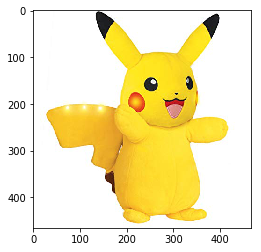

In [8]:
img = imread("10.jpg")
print img.shape
plt.imshow(img)
plt.show()

## Defining the model architecture

### Guidelines to define model architecture
- The feed forward network accepts a dictiontionay with input and layers as keys
- Store the input image or activation map in 'input' key of the dict
- key 'layers' is a list of dictionaries where each dict represents a layer and in the same as they are in the list
- each dict in layers should have a 'type' key which defines the type of the layer
- It supports four types of layers :
    - conv : Convolutional layer 2d
    - pool : Pooling layer
    - flat : flattening or unravell layer
    - fc   : fully connected or dense layer
#### Attributes for each layer
- conv:
    - filters (int) : Number of kernels
    - kernal  (int, int): kernel size, first value corresponds to row
    - stride  (int, int): Stride size
    - padding ('same' or 'valid):
        - 'same': the output shape will be same as input
        - 'valid': no padding will be done to the input
    - activation ('sigmoid' or 'relu' or 'tanh'): corresponding activation functions will be applied

- pool:
    - kernal  (int, int): kernel size, first value corresponds to row
    - stride  (int, int): Stride size
    - pool_func ('max' or 'average' or 'min'): corresponding pooling functions will be applied
    
- flat:
    - output_length (int) : output vector length
    
- fc:
    - nodes (int) : no of nodes in the corresponding layer
    - activation ('sigmoid' or 'relu' or 'tanh' or 'softmax'): corresponding activation functions will be applied

In [9]:
feed_dict = {}
feed_dict['input'] = img
feed_dict['layers'] = [{'type': 'conv', 'filters': 4 , 'kernel': (3,3) , 'stride': (2,2)  , 'padding': 'valid', 'activation': 'relu'},
                       {'type': 'conv', 'filters': 4 , 'kernel': (3,3) , 'stride': (2,2)  , 'padding': 'valid', 'activation': 'relu'},
                       {'type': 'pool', 'kernel': (2,2) , 'stride': (1,1),  'pool_func': 'max'},
                       {'type': 'conv', 'filters': 8 , 'kernel': (2,2) , 'stride': (1,1)  , 'padding': 'valid', 'activation': 'relu'},
                       {'type': 'conv', 'filters': 8 , 'kernel': (2,2) , 'stride': (1,1)  , 'padding': 'valid', 'activation': 'relu'},
                       {'type': 'pool', 'kernel': (2,2) , 'stride': (2,2),  'pool_func': 'max'},
                       {'type': 'flat', 'output_length': 2048},
                       {'type': 'fc',  'nodes': 1024, 'activation' : 'sigmoid'},
                       {'type': 'fc',  'nodes': 1024, 'activation' : 'sigmoid'},
                       {'type': 'fc',  'nodes': 10, 'activation' : 'sigmoid'}]

## buliding the model and fed forward the input

In [10]:
output = feed_forward(feed_dict)

print 'layer \t type \t output shape\n'
#printing the output layers with corresponding shape
for i in range(len(output)):
    print str(output[i]['layer_number']) + '\t' + str(output[i]['type']) + '\t' + str(output[i]['output'].shape) 

layer 	 type 	 output shape

0	conv	(232, 232, 4)
1	conv	(115, 115, 4)
2	pool	(114, 114, 4)
3	conv	(113, 113, 8)
4	conv	(112, 112, 8)
5	pool	(56, 56, 8)
6	flat	(2048,)
7	fc	(1024, 1)
8	fc	(1024, 1)
9	fc	(10, 1)


In [11]:
#printing the last output
print output[len(output) - 1]['output']

[[0.72467933]
 [0.72360681]
 [0.72577901]
 [0.73060894]
 [0.72494787]
 [0.73105858]
 [0.72715446]
 [0.72128104]
 [0.72138725]
 [0.72092858]]


0	conv


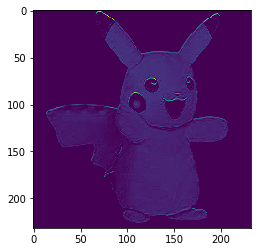

1	conv


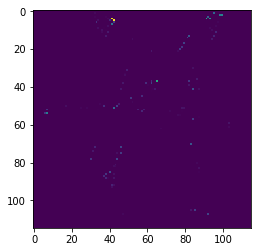

2	pool


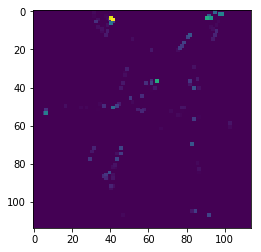

3	conv


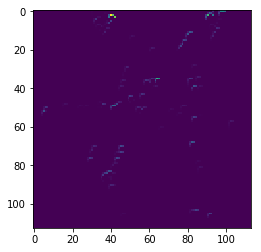

4	conv


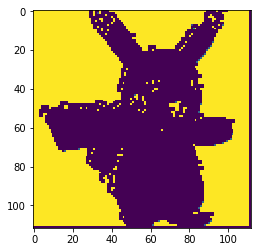

5	pool


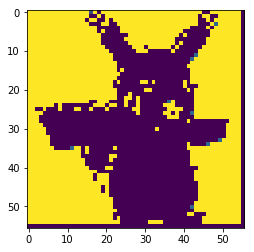

In [12]:
for i in range(len(output)):
    if(output[i]['type'] == 'conv' or output[i]['type'] == 'pool'):
        print str(output[i]['layer_number']) + '\t' + str(output[i]['type'])
        plt.imshow(output[i]['output'][:,:,0])
        plt.show()